# Preliminary EDA

### An Advanced Persistent Threat (APT) is a type of cyber attack where an attacker gains unauthorized access to a network and remains undetected for an extended period of time. The goal of an APT is usually to steal sensitive information or to disrupt critical systems. APT attacks are usually carried out by well-funded and highly skilled attackers, such as nation-state actors or organized criminal groups.

### The objective of this project is to identify an APT and determine remedial actions

In [1]:
## Import Functions and Spark Config
from pyspark.sql.functions import sum
from pyspark.sql.functions import avg
from pyspark.sql.functions import desc
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

In [2]:
%run ./read_file.ipynb

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/18 18:07:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/02/18 18:07:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Set Environment

In [3]:
# env can be dev or prod
env = "dev"

## Part 1: Load Data

#### Load bro data (Network Data)

In [4]:
df_bro = readCheckpoint('bro', env)

23/02/18 18:07:11 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


--- 9.886786699295044 seconds ---


In [5]:
df_bro.printSchema()

root
 |-- ts: string (nullable = true)
 |-- uid: string (nullable = true)
 |-- id.orig_h: string (nullable = true)
 |-- id.orig_p: string (nullable = true)
 |-- id.resp_: string (nullable = true)
 |-- id.resp_p: string (nullable = true)
 |-- proto: string (nullable = true)
 |-- service: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- orig_bytes: string (nullable = true)
 |-- resp_bytes: string (nullable = true)
 |-- conn_state: string (nullable = true)
 |-- local_orig: string (nullable = true)
 |-- local_resp: string (nullable = true)
 |-- missed_bytes: string (nullable = true)
 |-- history: string (nullable = true)
 |-- orig_pkts: string (nullable = true)
 |-- orig_ip_bytes: string (nullable = true)
 |-- resp_pkts: string (nullable = true)
 |-- resp_ip_bytes: string (nullable = true)
 |-- tunnel_parents: string (nullable = true)



#### Business Glossary for Network Data

| Column Name   | Description                                                                                   |
|---------------|-----------------------------------------------------------------------------------------------|
| ts            | Unix timestamp (seconds since epoch)                                                          |
| uid           | A unique identifier for each connection                                                        |
| id.orig_h     | IP address of the host that initiated the connection                                          |
| id.orig_p     | Port number used by the host that initiated the connection                                     |
| id.resp_h     | IP address of the host that received the connection                                            |
| id.resp_p     | Port number used by the host that received the connection                                      |
| proto         | Network protocol used for the connection (e.g. TCP, UDP)                                       |
| service       | Service used for the connection (e.g. http, ftp)                                               |
| duration      | Length of time (in seconds) that the connection was active                                     |
| orig_bytes    | Number of bytes transmitted by the host that initiated the connection                         |
| resp_bytes    | Number of bytes transmitted by the host that received the connection                          |
| conn_state    | Current state of the connection                                                               |
| local_orig    | Indicates whether the connection was initiated by a local host                                |
| local_resp    | Indicates whether the connection was received by a local host                                 |
| missed_bytes  | Number of bytes that were lost during transmission                                             |
| history       | Record of the connection history                                                              |
| orig_pkts     | Number of packets transmitted by the host that initiated the connection                       |
| orig_ip_bytes | Number of IP bytes transmitted by the host that initiated the connection                       |
| resp_pkts     | Number of packets transmitted by the host that received the connection                        |
| resp_ip_bytes | Number of IP bytes transmitted by the host that received the connection                        |
| tunnel_parents| Identifies any parent connections for the connection (if any)                                  |


#### Load ecarbro data (Link Data between records in the ecar stream and bro tables)

In [59]:
df_ecarbro = readCheckpoint('ecar-bro', env)

--- 0.38562464714050293 seconds ---


In [60]:
df_ecarbro.printSchema()

root
 |-- action: string (nullable = true)
 |-- actorID: string (nullable = true)
 |-- hostname: string (nullable = true)
 |-- id: string (nullable = true)
 |-- object: string (nullable = true)
 |-- objectID: string (nullable = true)
 |-- pid: long (nullable = true)
 |-- ppid: long (nullable = true)
 |-- principal: string (nullable = true)
 |-- tid: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- acuity_level: string (nullable = true)
 |-- bro_uid: string (nullable = true)
 |-- dest_ip: string (nullable = true)
 |-- dest_port: string (nullable = true)
 |-- direction: string (nullable = true)
 |-- image_path: string (nullable = true)
 |-- l4protocol: string (nullable = true)
 |-- src_ip: string (nullable = true)
 |-- src_port: string (nullable = true)



#### Business Glossary for Link Data


| Column Name  | Description                                                                                     |
|--------------|-------------------------------------------------------------------------------------------------|
| action       | Action performed in the event                                                                   |
| actorID      | Unique ID of the actor who performed the action                                                 |
| hostname     | Hostname of the system where the action was performed                                           |
| id           | ID associated with the event                                                                    |
| object       | Object related to the event                                                                     |
| objectID     | Unique ID of the object related to the event                                                    |
| pid          | Process ID associated with the event                                                            |
| ppid         | Parent process ID associated with the event                                                     |
| principal    | Principal associated with the event                                                              |
| tid          | Thread ID associated with the event                                                              |
| timestamp    | Time when the event occurred                                                                    |
| acuity_level | Acuity level associated with the event                                                           |
| bro_uid      | Bro unique identifier associated with the event                                                 |
| dest_ip      | IP address of the destination of the event                                                       |
| dest_port    | Port number of the destination of the event                                                      |
| direction    | Direction of the event (inbound/outbound)                                                        |
| image_path   | Path of the image associated with the event                                                      |
| l4protocol   | Layer 4 protocol used in the event                                                               |
| src_ip       | IP address of the source of the event                                                            |
| src_port     | Port number of the source of the event                                                           |


#### Load ecar data (Endpoint Data, e.g. PC, Smartphone, Router, IOT device, etc.)

In [61]:
df_ecar = readCheckpoint('ecar', env)

--- 0.34322047233581543 seconds ---


In [62]:
df_ecar.printSchema()

root
 |-- action: string (nullable = true)
 |-- actorID: string (nullable = true)
 |-- hostname: string (nullable = true)
 |-- id: string (nullable = true)
 |-- object: string (nullable = true)
 |-- objectID: string (nullable = true)
 |-- pid: long (nullable = true)
 |-- ppid: long (nullable = true)
 |-- principal: string (nullable = true)
 |-- tid: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- acuity_level: string (nullable = true)
 |-- base_address: string (nullable = true)
 |-- command_line: string (nullable = true)
 |-- context_info: string (nullable = true)
 |-- data: string (nullable = true)
 |-- dest_ip: string (nullable = true)
 |-- dest_port: string (nullable = true)
 |-- direction: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- file_path: string (nullable = true)
 |-- image_path: string (nullable = true)
 |-- info_class: string (nullable = true)
 |-- key: string (nullable = true)
 |-- l4protocol: string (nullable = true)
 |-- logo

#### Business Glossary for Endpoint Data

| Column Name      | Description                                                |
|------------------|------------------------------------------------------------|
| action           | The type of action performed (e.g. CREATE, REMOTE_CREATE)   |
| actorID          | A unique identifier for the entity that initiated the action|
| hostname         | The name of the host where the action was performed         |
| id               | A unique identifier for the action                          |
| object           | The type of object affected by the action (e.g. THREAD)     |
| objectID         | A unique identifier for the object affected by the action   |
| pid              | The process ID of the process that initiated the action     |
| ppid             | The parent process ID of the process that initiated the action|
| principal        | The identity of the user or application that performed the action|
| tid              | The thread ID of the thread that initiated the action        |
| task_process_uuid| A unique identifier for the process in which the action was performed|
| tgt_pid          | The process ID of the target process affected by the action |
| tgt_pid_uuid     | A unique identifier for the target process affected by the action|
| tgt_tid          | The thread ID of the target thread affected by the action    |
| type             | The type of action performed (e.g. THREAD)                  |
| user             | The identity of the user that performed the action           |
| user_name        | The name of the user that performed the action               |
| user_stack_base  | The base address of the stack for the user that performed the action|
| user_stack_limit | The limit address of the stack for the user that performed the action|
| value            | The value associated with the action                         |


## Part 2: EDA

#### Network Data (bro)

In [63]:
# Count the number of rows in the DataFrame
print('Total number of rows:', df_bro.count())

# update column names from period to underscore
df_bro = df_bro.withColumnRenamed("id.orig_h", "id_orig_h") \
               .withColumnRenamed("id.orig_p", "id_orig_p") \
               .withColumnRenamed("id.resp_", "id_resp_h") \
               .withColumnRenamed("id.resp_p", "id_resp_p")

# Show the first 5 rows of the DataFrame
df_bro.limit(5).toPandas()

Total number of rows: 1638512


,ts,uid,id_orig_h,id_orig_p,id_resp_h,id_resp_p,proto,service,duration,orig_bytes,...,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents
0,1569229689.859149,CfyCKh3MsRTpugdvj,142.20.59.103,50833,211.25.186.5,80,tcp,http,0.006784,283,...,SF,F,F,0,ShADadfF,5,495,5,824,(empty)
1,1569229689.855722,Cz0OEs4TjedsnhJXBe,142.20.57.200,50491,165.101.35.5,443,tcp,ssl,0.012456,917,...,SF,F,F,0,ShADadfF,7,1209,8,1084,(empty)
2,1569229689.890041,Ceom8t1Bh1ckezFB4l,142.20.57.200,50495,165.101.35.5,443,tcp,ssl,0.011329,917,...,SF,F,F,0,ShADadfF,7,1209,8,1084,(empty)
3,1569229682.895720,CdjoLx4lc0kxqLCP46,142.20.58.204,56854,5.221.97.162,80,tcp,http,7.019516,3534,...,SF,F,F,0,ShADadfF,50,5546,375,474840,(empty)
4,1569229690.002058,CCRq341myqJPGvb04f,142.20.59.103,50839,211.25.186.5,80,tcp,http,0.004701,283,...,SF,F,F,0,ShADadfF,5,495,5,824,(empty)


In [64]:
# Describe the numerical columns of the DataFrame
description = df_bro.select('duration', 'orig_bytes', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes').describe()

# Convert the describe dataframe to a pandas dataframe
pandas_df = description.toPandas()

# Set the index to the statistics
pandas_df.set_index('summary', inplace=True)

# Print the pandas dataframe
print(pandas_df)



                  duration          orig_bytes missed_bytes  \
summary                                                       
count              1638512             1638512      1638512   
mean     0.452717434888676  1046.1982514584404          0.0   
stddev   5.934483768224415   3241.688502450323          0.0   
min                      -                   -            0   
max              99.993716                9998            0   

                  orig_pkts       orig_ip_bytes           resp_pkts  \
summary                                                               
count               1638512             1638512             1638512   
mean     10.279075771187516  1499.3708431796654  27.273308343179664   
stddev   12.827937693393125  3459.1386051086124  115.63798628076405   
min                       1                1000                   0   
max                      99                9999                 999   

              resp_ip_bytes  
summary                      


In [65]:
# Group the DataFrame by protocol and count the number of occurrences for each protocol
print("\033[1mCommentary:\033[0m A protocol is like a set of rules that computers use to talk to each other and send information over the internet. Think of it like a secret code that helps the computers understand each other and send the right information. In our data, we see different types of protocols and will investigate if any protocol is more conducive to malicious activity.")
df_bro.groupBy('proto').count().orderBy(desc('count')).show()

# Group the DataFrame by service and count the number of occurrences for each service
print("\033[1mCommentary:\033[0m Services are used by computers to communicate with each other over the internet.")
df_bro.groupBy('service').count().orderBy(desc('count')).show()

# Find the top 5 host pairs with the highest number of connections
df_bro.groupBy('id_orig_h', 'id_resp_h').count().orderBy(desc('count')).show(5)

# Find the total number of bytes sent and received for each host
df_bro.groupBy('id_orig_h')\
      .agg(sum('orig_bytes').alias('total_orig_bytes'), \
           sum('resp_bytes').alias('total_resp_bytes'))\
      .orderBy('total_orig_bytes', ascending=False)\
      .show()

# Find the average duration of connections for each service
from pyspark.sql.functions import avg
df_bro.groupBy('service').agg(avg('duration').alias('avg_duration')).orderBy(desc('avg_duration')).show()


Commentary: A protocol is like a set of rules that computers use to talk to each other and send information over the internet. Think of it like a secret code that helps the computers understand each other and send the right information. In our data, we see different types of protocols and will investigate if any protocol is more conducive to malicious activity.


+-----+-------+
|proto|  count|
+-----+-------+
|  tcp|1632124|
|  udp|   6345|
| icmp|     43|
+-----+-------+

Commentary: Services are used by computers to communicate with each other over the internet.


+--------+-------+
| service|  count|
+--------+-------+
|     ssl|1543302|
|    http|  82258|
|     dns|   6339|
|       -|   5679|
|ssl,smtp|    515|
|smtp,ssl|    419|
+--------+-------+



+-------------+------------+-----+
|    id_orig_h|   id_resp_h|count|
+-------------+------------+-----+
|142.20.57.186|165.101.35.5|14361|
| 142.20.58.37|165.101.35.5| 9806|
|142.20.57.191|165.101.35.5| 9383|
| 142.20.56.17|165.101.35.5| 7389|
|142.20.56.166|165.101.35.5| 7324|
+-------------+------------+-----+
only showing top 5 rows



+-------------+----------------+----------------+
|    id_orig_h|total_orig_bytes|total_resp_bytes|
+-------------+----------------+----------------+
|  142.20.61.3|     1.8028047E7|       1253215.0|
|142.20.57.186|     1.3627406E7|     2.1404376E7|
|142.20.57.191|     1.1802049E7|    1.16068112E8|
| 142.20.58.37|     1.1147826E7|    1.16560545E8|
|142.20.59.101|       9953407.0|    1.67103282E8|
|142.20.57.166|       9677542.0|    1.21657509E8|
|  142.20.59.1|       9201655.0|     9.4671044E7|
| 142.20.56.17|       9156803.0|     9.5098735E7|
| 142.20.57.43|       9012681.0|    1.15895796E8|
|142.20.58.221|       8997579.0|       7433034.0|
|142.20.56.143|       8711087.0|    1.03977266E8|
|142.20.56.166|       8562912.0|     8.4115092E7|
|142.20.58.233|       8561463.0|     6.9078277E7|
|142.20.58.137|       7888560.0|    1.26267582E8|
| 142.20.58.83|       7802983.0|     6.5331777E7|
|142.20.57.144|       7695684.0|     4.3577907E7|
| 142.20.59.57|       7147499.0|    1.96279479E8|


+--------+--------------------+
| service|        avg_duration|
+--------+--------------------+
|    http|  7.9022473594179345|
|smtp,ssl|  3.0048657040572793|
|ssl,smtp|  2.9483941223300962|
|       -|   1.037497518551394|
|     ssl|  0.0538303094630861|
|     dns|0.001333372586564...|
+--------+--------------------+



#### Link Data (ecarbro)

In [20]:
# Count the number of rows in the DataFrame
print('Total number of rows:', df_ecarbro.count())

# Show the first 5 rows of the DataFrame
df_ecarbro.limit(5).toPandas()

Total number of rows: 1000


,action,actorID,hostname,id,object,objectID,pid,ppid,principal,tid,timestamp,acuity_level,bro_uid,dest_ip,dest_port,direction,image_path,l4protocol,src_ip,src_port
0,INFO,4767c80e-1e6b-412e-9432-fad5898fa7db,SysClient0024.systemia.com,2ea7d45b-0a28-4d92-8ca7-58502d1ba631,FLOW,dfaf05b2-4d7c-408d-bb0f-d56f52b07f12,5920,-1,,-1,2019-09-23T09:10:15.593-04:00,1,C46Z8E9qAFrZ8Iks4,195.219.101.2,80,outbound,None,6,142.20.56.25,63394
1,INFO,4767c80e-1e6b-412e-9432-fad5898fa7db,SysClient0024.systemia.com,264c42c4-7914-4e76-809f-982fe0b241d0,FLOW,6ea8ef0c-6450-4e39-b473-c7d3d53578f3,5920,-1,,-1,2019-09-23T09:10:15.623-04:00,1,Chrr5B4nTDEYBgYjme,195.219.101.5,80,outbound,None,6,142.20.56.25,63395
2,INFO,4767c80e-1e6b-412e-9432-fad5898fa7db,SysClient0024.systemia.com,3f057bc7-a39e-487e-8490-eb77f5bb6ed6,FLOW,6558c991-e5a0-409d-b5b9-96a3e44c747a,5920,-1,,-1,2019-09-23T09:10:15.635-04:00,1,CvZy4E919XjWUGVD4,195.219.101.5,443,outbound,None,6,142.20.56.25,63396
3,INFO,4767c80e-1e6b-412e-9432-fad5898fa7db,SysClient0024.systemia.com,71978192-53c8-4cfa-a79f-193d760c3b01,FLOW,d57caaa4-66ec-400a-b305-049fa912b1dd,5920,-1,,-1,2019-09-23T09:10:15.789-04:00,1,CXUYLX9hxem2or1bh,195.219.101.5,443,outbound,None,6,142.20.56.25,63397
4,INFO,4767c80e-1e6b-412e-9432-fad5898fa7db,SysClient0024.systemia.com,d02151e6-c183-46e2-82e0-0ed9eded3c92,FLOW,54530c7c-0b65-4ba9-a0c1-891d3e4e4efa,5920,-1,,-1,2019-09-23T09:10:15.79-04:00,1,Cv9qwV2jFSOU4wpBu9,195.219.101.5,443,outbound,None,6,142.20.56.25,63398


In [21]:
# Types of object/action pairs and their count

df_ecarbro.groupBy("object","action").count().show()

+------+------+-----+
|object|action|count|
+------+------+-----+
|  FLOW|  INFO| 1000|
+------+------+-----+



#### Endpoint Data (ecarbro)

In [22]:
# Count the number of rows in the DataFrame
print('Total number of rows:', df_ecar.count())

# Show the first 5 rows of the DataFrame
df_ecar.limit(5).toPandas()

Total number of rows: 1000
23/02/18 17:13:35 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,action,actorID,hostname,id,object,objectID,pid,ppid,principal,tid,...,task_process_uuid,tgt_pid,tgt_pid_uuid,tgt_tid,type,user,user_name,user_stack_base,user_stack_limit,value
0,CREATE,89f91b70-9613-4e70-9473-23bb029e3889,SysClient0004.systemia.com,97e0d110-cc53-4baf-a293-4646e6d967a9,THREAD,9e902e20-df97-4120-8ed5-01b61980bab8,312,-1,,4548,...,None,312,None,3332,None,None,None,3631f00000,3631ef8000,None
1,CREATE,89f91b70-9613-4e70-9473-23bb029e3889,SysClient0004.systemia.com,9adb7fc5-73f3-4567-8f6b-adbbc4a9ba3d,THREAD,bafe59cd-d8af-4be1-96b1-e7c727c1aec8,312,-1,,4548,...,None,312,None,3188,None,None,None,3632000000,3631ff8000,None
2,CREATE,89f91b70-9613-4e70-9473-23bb029e3889,SysClient0004.systemia.com,4fc209b1-c5e4-49a2-94ec-d2310f211a02,THREAD,99e6ee71-6469-421e-b0c4-198a8e508488,312,-1,,1640,...,None,312,None,2140,None,None,None,3632100000,36320f8000,None
3,REMOTE_CREATE,ff8a4d62-eb4a-4cfc-aea2-1870d4dba3f1,SysClient0004.systemia.com,a7624d42-57d8-4c31-bc71-191f8be09a49,THREAD,2d085a9f-c563-4fad-b86c-b035ba199f0b,1880,-1,,2776,...,None,4,aa240ddc-17cd-4f29-bb39-e40a51f088b2,3676,None,None,None,0,0,None
4,CREATE,88984aa1-d004-41d9-a498-8e9eab111f62,SysClient0022.systemia.com,77bb2643-59a8-45e0-ad50-b198a4d8e5f0,THREAD,0ef70c6e-6aa3-4d5c-b74a-e902b630b25d,364,-1,,2612,...,None,364,None,4352,None,None,None,6b08500000,6b084f8000,None


In [23]:
# Types of object/action pairs and their count

df_ecar.groupBy("object", "action").count().orderBy(desc("count")).show()

+------------+-------------+-----+
|      object|       action|count|
+------------+-------------+-----+
|        FLOW|        START|  350|
|      MODULE|         LOAD|  229|
|      THREAD|       CREATE|  114|
|        FLOW|      MESSAGE|  112|
|      THREAD|    TERMINATE|  105|
|      THREAD|REMOTE_CREATE|   22|
|    REGISTRY|         EDIT|   13|
|     PROCESS|         OPEN|   13|
|     PROCESS|    TERMINATE|   12|
|     PROCESS|       CREATE|   11|
|        FILE|       DELETE|    6|
|        FILE|         READ|    4|
|        FILE|       CREATE|    3|
|USER_SESSION|        GRANT|    2|
|        FILE|        WRITE|    2|
|USER_SESSION|        LOGIN|    2|
+------------+-------------+-----+



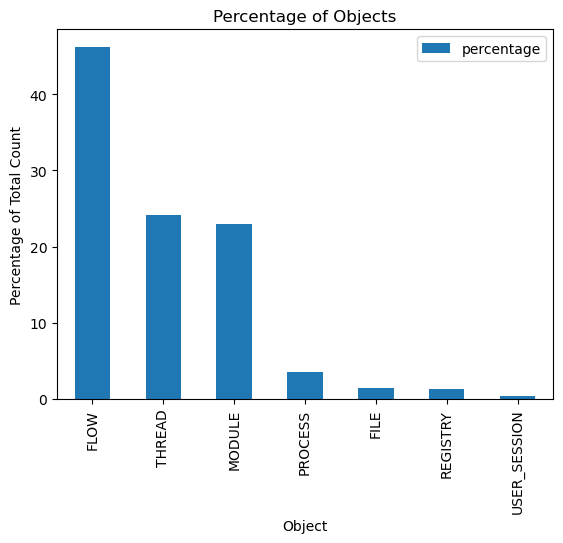

In [26]:
# Import necessary libraries
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt

# Group and aggregate data
df_grouped = df_ecar.groupBy("object").agg(F.count("*").alias("count"))

# Calculate percentage of total count
total_count = df_grouped.agg(F.sum("count")).collect()[0][0]
df_grouped = df_grouped.withColumn("percentage", F.round((F.col("count")/total_count)*100, 2))

# Order by count
df_grouped = df_grouped.orderBy(desc("count"))

# Convert PySpark DataFrame to Pandas DataFrame
df_pd = df_grouped.toPandas()

# Plot bar chart
df_pd.plot(x='object', y='percentage', kind='bar')
plt.xlabel('Object')
plt.ylabel('Percentage of Total Count')
plt.title('Percentage of Objects')
plt.show()


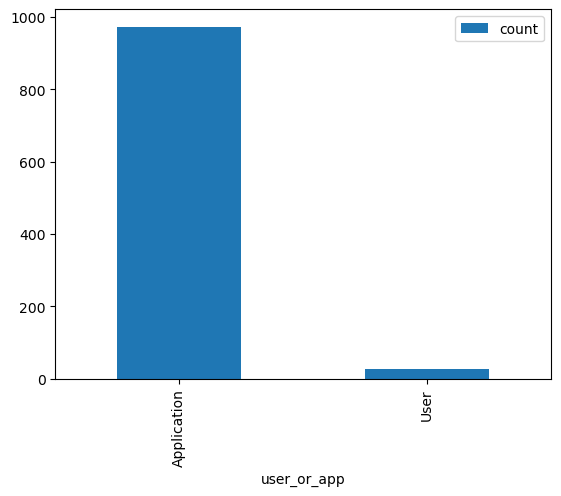

In [29]:
# Create new column for user/application
df_ecar = df_ecar.withColumn('user_or_app', F.when(F.col('user').isNull(), 'Application').otherwise('User'))

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df_ecar.groupBy("user_or_app").count().orderBy(desc("count")).toPandas()

# Plot bar chart
pandas_df.plot(kind="bar", x="user_or_app", y="count")
plt.show()



In [31]:
# Calculate the object and actorID pairs relative to the total number of events

# Compute total count of events
total_count = df_ecar.count()

# Group by object and actorID, and count the number of events
df_grouped = df_ecar.groupBy("object", "actorID").agg(F.count("*").alias("count"))

# Calculate percentage of total count
df_grouped = df_grouped.withColumn("percentage", F.round((F.col("count")/total_count)*100, 2))

# Order by count in descending order and display top 5
df_top_5 = df_grouped.orderBy(F.desc("count")).limit(5)

# Show the result
df_top_5.show()

+------+--------------------+-----+----------+
|object|             actorID|count|percentage|
+------+--------------------+-----+----------+
|  FLOW|dc86e012-8306-46d...|  255|      25.5|
|  FLOW|aa240ddc-17cd-4f2...|  164|      16.4|
|THREAD|88984aa1-d004-41d...|   77|       7.7|
|THREAD|89f91b70-9613-4e7...|   40|       4.0|
|MODULE|f84b7804-d1b3-4ff...|   35|       3.5|
+------+--------------------+-----+----------+

